In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


from sklearn.linear_model import LogisticRegression


from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.ensemble import IsolationForest


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, adjusted_rand_score, precision_recall_curve

from sklearn.svm import OneClassSVM

from scipy.stats import uniform, chisquare, binomtest

from itertools import product

from IPython.display import clear_output


In [2]:
# load data

data_heatmap = pd.read_csv('../datasets/train/data_heatmap_train.csv')
data_metrics = pd.read_csv('../datasets/train/data_metrics_train.csv')

In [3]:
cb_333519 = ['ID_1184', 'ID_1281', 'ID_1305', 'ID_1353', 'ID_1448', 'ID_1522',
       'ID_1544', 'ID_162', 'ID_1682', 'ID_1690', 'ID_1824', 'ID_1888',
       'ID_1929', 'ID_2076', 'ID_2097', 'ID_2226', 'ID_2249', 'ID_2268',
       'ID_2331', 'ID_2339', 'ID_2386', 'ID_2396', 'ID_2438', 'ID_258',
       'ID_2609', 'ID_2680', 'ID_2863', 'ID_2883', 'ID_2908', 'ID_3061',
       'ID_3243', 'ID_3250', 'ID_3314', 'ID_3382', 'ID_3397', 'ID_3402',
       'ID_3420', 'ID_3459', 'ID_3470', 'ID_3540', 'ID_398', 'ID_409',
       'ID_484', 'ID_489', 'ID_526', 'ID_549', 'ID_580', 'ID_665',
       'ID_810', 'ID_84', 'ID_857', 'ID_86', 'ID_905', 'ID_927', 'ID_934',
       'ID_962', 'ID_986']

cb_333346 = ['ID_1247', 'ID_162', 'ID_2534', 'ID_2742', 'ID_526', 'ID_2201',
       'ID_1165', 'ID_743', 'ID_199', 'ID_2145', 'ID_2569', 'ID_643',
       'ID_1305', 'ID_3180', 'ID_3158', 'ID_136', 'ID_293', 'ID_1753',
       'ID_1849', 'ID_2226', 'ID_1462', 'ID_626', 'ID_2863', 'ID_3243',
       'ID_3250', 'ID_1708', 'ID_1238', 'ID_580', 'ID_84', 'ID_2568',
       'ID_2340', 'ID_1803', 'ID_3470', 'ID_139', 'ID_2619', 'ID_2908',
       'ID_1281', 'ID_3308', 'ID_2883', 'ID_1320', 'ID_1333', 'ID_1062',
       'ID_149', 'ID_260', 'ID_599', 'ID_1513', 'ID_3402', 'ID_1888',
       'ID_2972', 'ID_398', 'ID_2339', 'ID_1030', 'ID_3382', 'ID_2076',
       'ID_1646', 'ID_1077', 'ID_10', 'ID_1153', 'ID_1533', 'ID_2609',
       'ID_1214', 'ID_810', 'ID_2097', 'ID_2386', 'ID_1585', 'ID_549',
       'ID_3420', 'ID_3397', 'ID_2006', 'ID_561', 'ID_1542', 'ID_1570',
       'ID_1819', 'ID_1413', 'ID_1240', 'ID_793', 'ID_831', 'ID_3188',
       'ID_1437', 'ID_556', 'ID_1134', 'ID_314', 'ID_2836', 'ID_1483',
       'ID_2676', 'ID_665', 'ID_15', 'ID_2755', 'ID_2194', 'ID_1682',
       'ID_2775', 'ID_1923', 'ID_1846', 'ID_1262', 'ID_3314', 'ID_1448',
       'ID_1770', 'ID_2626', 'ID_3296', 'ID_489', 'ID_1963', 'ID_1268',
       'ID_1568', 'ID_1094', 'ID_2267', 'ID_409', 'ID_1650', 'ID_1522',
       'ID_927', 'ID_2302', 'ID_1929', 'ID_1435', 'ID_1353']

#cb_333346_tentative_addtl = ['ID_962','ID_1894','ID_2274']

# 1. Metrics

In [4]:
# metrics dataframe:

dm = data_metrics.drop(columns = ['grid_id','domain','Unnamed: 0','webview_height','webview_width'])

data_metrics = data_metrics.drop(data_metrics.loc[data_metrics.broken.isna()].index)

# here I'm dropping NaN's -- alternative strategies are to impute it
data_metrics.dropna()

y = data_metrics['broken']
X = data_metrics.drop(columns = ['grid_id','domain','Unnamed: 0',
                                 'webview_height','webview_width','broken']).ffill(0)

X = X.drop(columns = ['clicks','sov_short_ttc','non_bounced_clicks','displays'])

X_train, X_test, y_train , y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 1)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# 2. Heatmap

In [5]:
# Heatmap dataset preprocessing:

data_heatmap_expanded = data_heatmap.loc[data_heatmap.index.repeat(
    data_heatmap['clicks'])].reset_index(drop=True)
data_heatmap_expanded['clicks'] = 1

click_stat = data_heatmap_expanded.groupby(['click_x','click_y'])['clicks'].count().reset_index()

# Binning clicks in nr_of_x_bins, nr_of_y_bins:

NR_OF_X_BINS = 61
NR_OF_Y_BINS = 51

max_width = data_heatmap['display_width'].max()
max_height = data_heatmap['display_height'].max()

width_bins = np.linspace(1, max_width, NR_OF_X_BINS)
height_bins = np.linspace(1, max_height, NR_OF_Y_BINS)

width_bins_max = len(width_bins)-2 # start at 0
height_bins_max = len(height_bins)-2

data_heatmap_expanded['click_x_bin'] = pd.cut(data_heatmap_expanded['click_x'], 
                                      bins   = width_bins, 
                                      labels = False, 
                                      include_lowest = True)

data_heatmap_expanded['click_y_bin'] = pd.cut(data_heatmap_expanded['click_y'], 
                                      bins = height_bins, 
                                      labels = False, 
                                      include_lowest = True)


aggregated_clicks = data_heatmap_expanded.groupby(['grid_id',
                                           'domain', 
                                           'click_x_bin', 
                                           'click_y_bin']).size().reset_index(name='clicks_sum')


aggregated_clicks['broken'] = 0
aggregated_clicks.loc[(aggregated_clicks.grid_id == 333519) &
            aggregated_clicks.domain.isin(cb_333519), 'broken'] = 1
aggregated_clicks.loc[(aggregated_clicks.grid_id == 333346) &
            aggregated_clicks.domain.isin(cb_333346), 'broken'] = 1


# 3. Combine

### 3.1.1. Run PCA on heatmap (HM)

In [6]:
# Choose grid:

# grid_id = 333519
# BROKEN_GRIDS = cb_333519

grid_id = 333346
BROKEN_GRIDS = cb_333346

# PCA features:
n_components  = 200

# Rerun the binning:

domains_grids = data_heatmap[['domain', 'grid_id']].drop_duplicates()

aux = pd.DataFrame(list(product(range(0,width_bins_max+1), 
                                range(0,height_bins_max+1))), 
                   columns=['click_x_bin', 'click_y_bin'])

domains_grids['key'] = 1
aux['key'] = 1

expanded_set = pd.merge(domains_grids, aux, on='key').drop('key', axis=1)

data_binned = pd.merge(expanded_set, aggregated_clicks, 
                  on = ['domain', 'grid_id', 'click_x_bin', 'click_y_bin'], 
                  how = 'left').fillna(0)
data_binned['clicks_sum'] = data_binned['clicks_sum'].astype('int64')
data_binned['broken'] = data_binned['broken'].astype('int64')

# Run PCA on heatmap:

data_binned = data_binned[data_binned['grid_id'] == grid_id]

pivot_df = pd.pivot_table(data_binned, values='clicks_sum', index=['domain', 'grid_id'],
                           columns=['click_x_bin', 'click_y_bin'], aggfunc='sum', fill_value=0)
pivot_df.reset_index(inplace=True)
pivot_df.columns = ['domain', 'grid_id'] + [f'clicks_sum_for_{x}_{y}' for x, y in pivot_df.columns[2:]]

x = pivot_df.copy()
x.iloc[:,2:] = (pivot_df.iloc[:,2:].transpose()/pivot_df.iloc[:,2:].sum(axis=1)).transpose()

features      = x.columns[2:]
pipeline      = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])
hm_pca_result = pipeline.fit_transform(x[features])
hm_pca_df     = pd.DataFrame(data = hm_pca_result, 
                             columns=[f'PC{i+1}' for i in range(n_components)])

### 3.1.2. Aside: Extract and Plot PCA vectors:

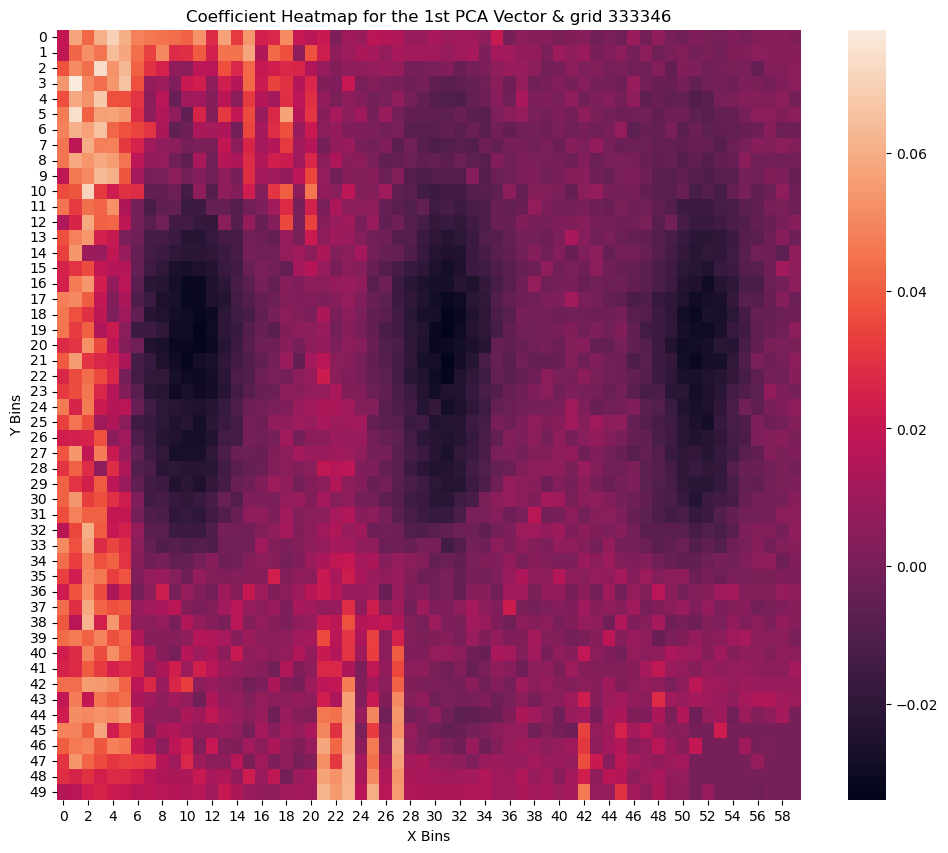

In [7]:
# extract PCA vectors

pca_vector_ = pipeline.named_steps['pca'].components_[0]

reshaped_vector = pca_vector_.reshape(NR_OF_X_BINS-1,NR_OF_Y_BINS-1).transpose()
#pivot_df[pivot_df.domain == 'ID_1501'].iloc[:,2:].values.reshape(NR_OF_X_BINS-1,NR_OF_Y_BINS-1).transpose() 
#first_pca_vector.reshape(NR_OF_Y_BINS-1, NR_OF_X_BINS-1)
reshaped_vector = np.flipud(reshaped_vector)

plt.figure(figsize=(12, 10))
sns.heatmap(reshaped_vector, annot=False)
plt.title(f'Coefficient Heatmap for the 1st PCA Vector & grid {grid_id}')
plt.xlabel('X Bins')
plt.ylabel('Y Bins')
plt.show()

### 3.1.3. PCA Visualization

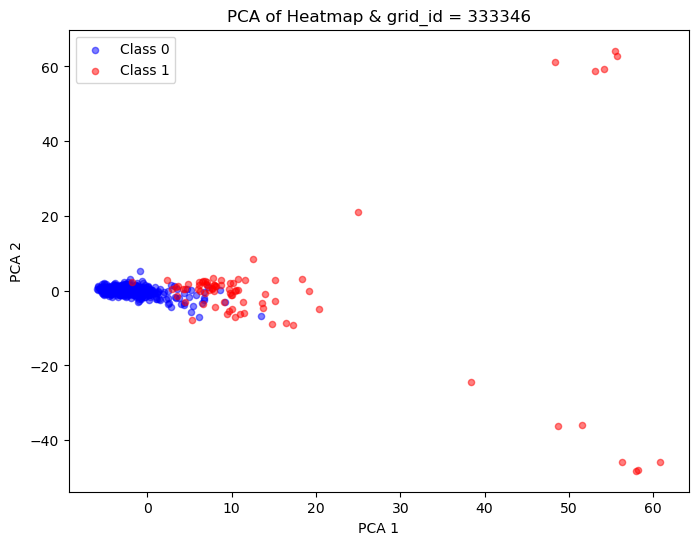

Cumulative explained variance by PCA component: [0.02688221 0.04524936 0.06078339 0.07293512 0.08335965 0.09204474
 0.10012266 0.10802759 0.11561316 0.12275562 0.12972942 0.13662913
 0.14320753 0.14972529 0.15610091 0.16224481 0.16831184 0.17424048
 0.18007001 0.18576372 0.19139657 0.19685055 0.20214702 0.20725533
 0.21232128 0.21710916 0.22179205 0.22644261 0.23103699 0.23552786
 0.23989262 0.24423705 0.24856901 0.25285552 0.25702175 0.26113602
 0.26521602 0.26924318 0.2732383  0.27717579 0.28102891 0.28486947
 0.2886835  0.29248588 0.29621559 0.29991619 0.30361177 0.30726559
 0.31088968 0.31450669 0.31805681 0.32159783 0.32510031 0.32857275
 0.3320359  0.335464   0.33886976 0.34225955 0.34563162 0.34899252
 0.3523261  0.35565364 0.35894872 0.36222719 0.36549067 0.36873531
 0.37196711 0.37517645 0.37837649 0.38156037 0.38474182 0.38789445
 0.39101841 0.39413089 0.39722594 0.40031041 0.40338634 0.40644497
 0.4094759  0.41248727 0.41547026 0.41844473 0.4214056  0.42436018
 0.42730526 0.

In [8]:
hm_pca_df['domain'] = x['domain']

hm_pca_df['label'] = 0
hm_pca_df.loc[hm_pca_df.domain.isin(BROKEN_GRIDS),'label'] = 1

hm_pca_np = hm_pca_df.values

plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    plt.scatter(hm_pca_np[hm_pca_np[:,-1] == label, 0], 
                hm_pca_np[hm_pca_np[:,-1] == label, 1], 
                c = color, 
                label = f'Class {label}', 
                alpha = 0.5,
                s = 20)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'PCA of Heatmap & grid_id = {grid_id}')
plt.legend()
plt.show()

explained_variance = np.cumsum(pipeline.named_steps['pca'].explained_variance_ratio_)
print(f"Cumulative explained variance by PCA component: {explained_variance}")
print(f"Total variance explained by 2 components: {(explained_variance[1]) * 100:.2f}%")

### 3.2.1 Run PCA on Metrics dataset 

This is not really necessary, the model with full metrics + pcaed heatmap performs better. See below

In [9]:
dm = data_metrics[data_metrics.grid_id == grid_id].drop(columns = 'Unnamed: 0').ffill(0)

dm_1 = dm.drop(columns = ['clicks','sov_short_ttc','non_bounced_clicks','displays'])
print(f'Remaining features in Metric dataset: {list(dm_1.columns[4:-1])}')

scaler    = StandardScaler()
dm_scaled = scaler.fit_transform(dm_1[dm_1.columns[4:-1]])

pca   = PCA(n_components = 2)
dm_pca = pca.fit_transform(dm_scaled)

X_pca_red = dm_pca[dm_pca[:, 0] < 20]
y_pca_red = dm['broken'].values[dm_pca[:, 0] < 20]

Remaining features in Metric dataset: ['landed_clicks', 'closing_events', 'avg_last_second_framerate', 'sov_short_ttc_global', 'sov_short_ttc_score']


### 3.2.2. Visualize Metric PCA (only have 5 features)

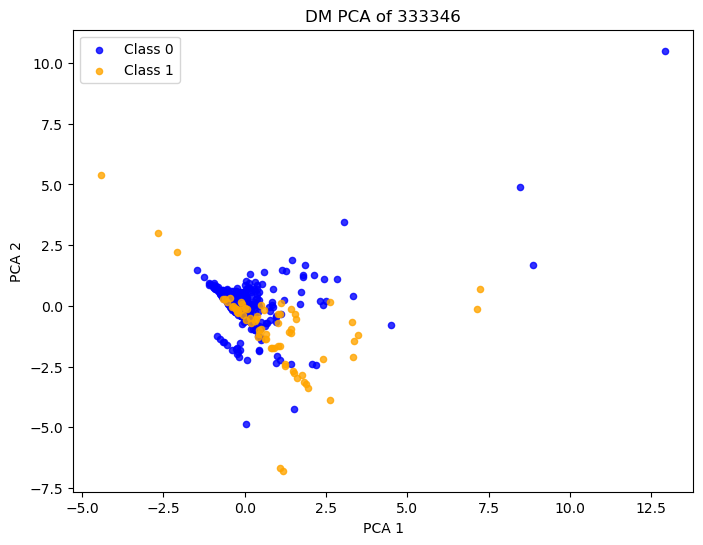

Explained variance by PCA component: [0.27415832 0.49740502]
Total variance explained by 2 components: 77.16%


In [10]:
plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'orange']):
    plt.scatter(X_pca_red[y_pca_red == label, 0], 
                X_pca_red[y_pca_red == label, 1], 
                c = color, 
                label = f'Class {label}', 
                alpha = 0.8,
                s = 20)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'DM PCA of {grid_id}')
plt.legend()
plt.show()

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Explained variance by PCA component: {explained_variance}")
print(f"Total variance explained by 2 components: {np.sum(explained_variance) * 100:.2f}%")

### 3.3.1. Combine pcaed dataframes

In [11]:
# make sure we only include the domains that are in the metrics dataset:

hm_pca_df_m = pd.merge(hm_pca_df, dm_1, on = 'domain').iloc[:,:20]
hm_pca_df_y = pd.merge(hm_pca_df, dm_1, on = 'domain')[['broken','label']]
#hm_pca_df_y['label'] = pd.merge(hm_pca_df, dm, on = 'domain').iloc[:,-1]

dm_pca_df = pd.DataFrame(data = dm_pca, columns = ['dm_pca1', 'dm_pca2'])

# simple check:
assert all(hm_pca_df_y.broken == hm_pca_df_y.label)

combined_pcas = pd.concat([hm_pca_df_m, dm_pca_df], axis = 1)

#### 3.3.1.1 Run PCA on combined dataset and visualize

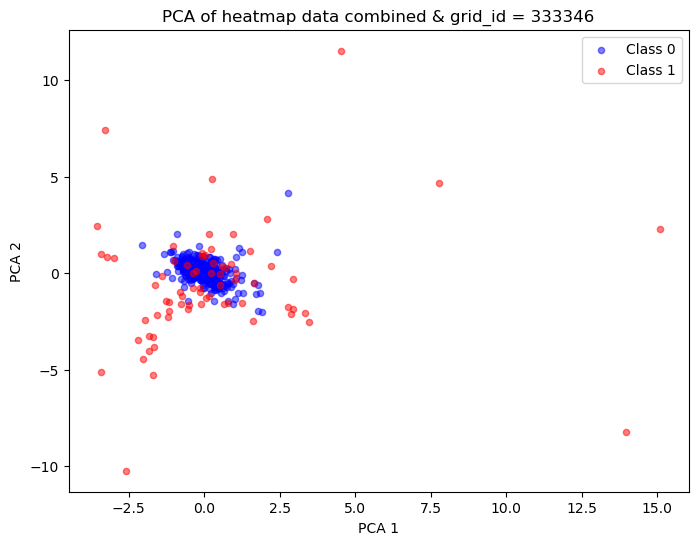

Cumulative explained variance by PCA component: [0.06589377 0.12848174 0.18592639 0.24310458 0.29517226 0.34593748
 0.39617631 0.44610982 0.49572625 0.54481294]
Total variance explained by 2 components: 12.85%


In [12]:
# Scale again and run pca again

combined_pca2x2 = StandardScaler().fit_transform(combined_pcas)
pca_2x2         = PCA(n_components = 10)
pca_2x2_trsf    = pca_2x2.fit_transform(combined_pca2x2)

plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    plt.scatter(pca_2x2_trsf[hm_pca_df_y['label'] == label, 0], 
                pca_2x2_trsf[hm_pca_df_y['label'] == label, 1], 
                c = color, 
                label = f'Class {label}', 
                alpha = 0.5,
                s = 20)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'PCA of heatmap data combined & grid_id = {grid_id}')
plt.legend()
plt.show()

explained_variance = np.cumsum(pca_2x2.explained_variance_ratio_)
print(f"Cumulative explained variance by PCA component: {explained_variance}")
print(f"Total variance explained by 2 components: {(explained_variance[1]) * 100:.2f}%")

### 3.3.2 Combine full Metrics with PCA-ed Heatmap (better)

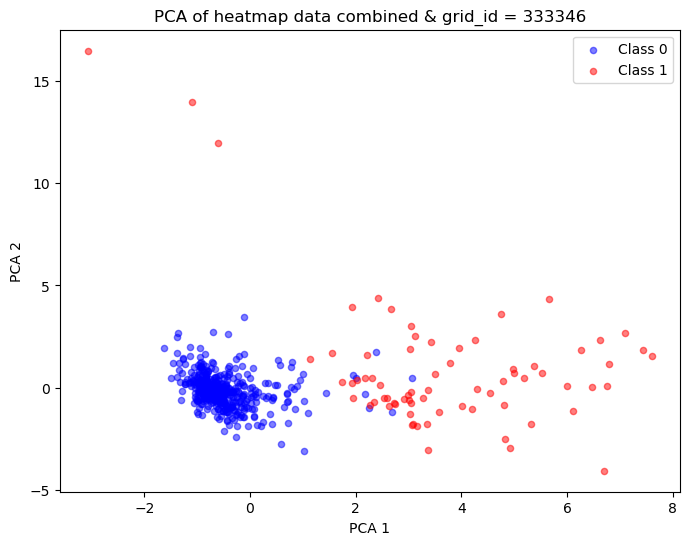

Cumulative explained variance by PCA component: [0.01285952 0.02236664 0.03097312 0.0389433  0.04644615 0.05367924
 0.06060833 0.06729303 0.07372177 0.07990861 0.08592345 0.09187646
 0.09775927 0.10358296 0.109324   0.11505241 0.12070845 0.12635093
 0.13195943 0.1375504  0.14313857 0.1487125  0.15424988 0.15976533
 0.16527376 0.17075775 0.17623455 0.18169616 0.18714163 0.19256132
 0.197968   0.20335249 0.20873319 0.21410555 0.21947149 0.22482752
 0.23018041 0.23552359 0.24086415 0.24618714 0.25150079 0.25681144
 0.26210132 0.26738581 0.27266283 0.27793515 0.28320527 0.28846503
 0.2937201  0.29897073 0.30421801 0.30945883 0.31469561 0.31992942
 0.32515691 0.33038237 0.33560376 0.34081468 0.34602032 0.35122384
 0.35642388 0.36162246 0.36681845 0.37200601 0.37719106 0.38237251
 0.38755197 0.39272844 0.39790326 0.40307129 0.40823833 0.41340413
 0.41856883 0.42372874 0.42888468 0.43403926 0.43919202 0.44434228
 0.44948952 0.45463542 0.45977999 0.46492167 0.47005985 0.47519598
 0.4803308  0.

In [13]:
merged_dm_hmpca   = pd.merge(hm_pca_df, dm_1, on = 'domain')[list(hm_pca_df.columns[:-2])+list(dm_1.columns[4:])]
merged_dm_hmpca_y = pd.merge(hm_pca_df, dm_1, on = 'domain')[['label']]
merged_domains    = pd.merge(hm_pca_df, dm_1, on = 'domain')[['domain']]

merged_dm_hmpca_scaled  = StandardScaler().fit_transform(merged_dm_hmpca)
pca_dm_hmpca            = PCA(n_components = n_components)
merged_dm_hmpca_pcaed   = pca_dm_hmpca.fit_transform(merged_dm_hmpca_scaled)

plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    plt.scatter(merged_dm_hmpca_pcaed[merged_dm_hmpca_y['label'] == label, 0], 
                merged_dm_hmpca_pcaed[merged_dm_hmpca_y['label'] == label, 1], 
                c = color, 
                label = f'Class {label}', 
                alpha = 0.5,
                s = 20)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title(f'PCA of heatmap data combined & grid_id = {grid_id}')
plt.legend()
plt.show()

explained_variance = np.cumsum(pca_dm_hmpca.explained_variance_ratio_)
print(f"Cumulative explained variance by PCA component: {explained_variance}")
print(f"Total variance explained by 2 components: {(explained_variance[1]) * 100:.2f}%")

# 4. Run clusters on combined dataset:

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, adjusted_rand_score, precision_recall_curve, precision_score, recall_score, f1_score

In [15]:
merged_dm_hmpca_pcaed.shape

(580, 200)

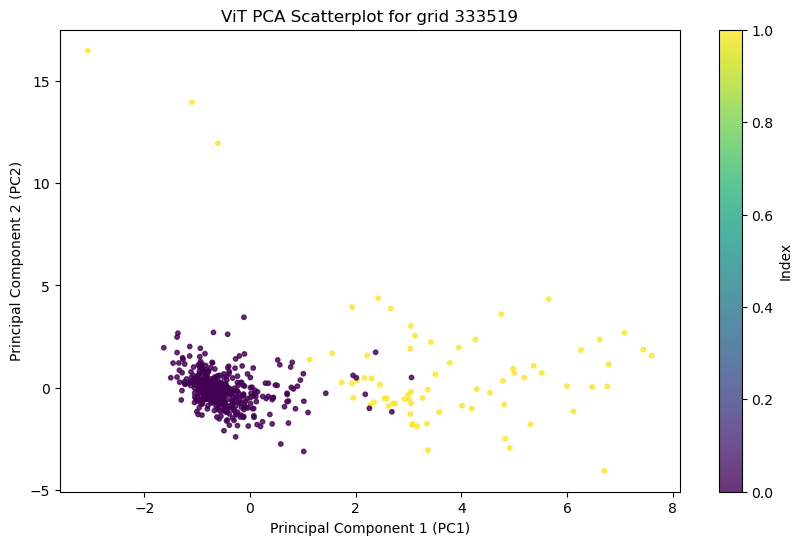

In [17]:
pca_df = pd.DataFrame(data = merged_dm_hmpca_pcaed, columns = ['PCA'+str(i) for i in range(1,n_components+1)])
pca_df['domain'] = merged_domains
pca_df['label'] = merged_dm_hmpca_y
actual_labels = merged_dm_hmpca_y.values

# quick check that our pca_df is correctly defined
plt.figure(figsize=(10, 6))
plt.scatter(pca_df.iloc[:,0],
            pca_df.iloc[:,1],
            c=pca_df['label'],
            cmap='viridis',
            alpha=0.8,
            s = 10)
plt.title('ViT PCA Scatterplot for grid 333519')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Index')
plt.show()

In [18]:
# One Class SVM

print('------------------------ SVM ------------------------')

y = pca_df[['label']]

pca_df_inp = pca_df.iloc[:,:-2]
best_acc = -1
best_dim = -1
best_recall = -1
best_prec = -1
best_f1 = -1

for pca_dim in np.linspace(2,200,198).astype(int):
    X = pca_df_inp.iloc[:,:pca_dim]

    oneclass = OneClassSVM(gamma = 'auto').fit(X)
    oneclass_labels = oneclass.predict(X)

    oneclass_labels = np.where(oneclass_labels == 1, 0,1)

    conf_mat   = confusion_matrix(actual_labels,oneclass_labels)
    acc        = accuracy_score(actual_labels,oneclass_labels)
    recall     = recall_score(actual_labels,oneclass_labels)
    prec       = precision_score(actual_labels,oneclass_labels)
    f1         = f1_score(actual_labels,oneclass_labels)

    if f1 > best_f1:
        best_f1  = f1
        best_acc = acc
        best_dim = pca_dim
        best_recall  = recall
        best_prec = prec

        best_oneclass_labels = oneclass_labels

        print(f'Confusion matrix for {pca_dim} PCA dimensions:\n',
              f' {conf_mat}')
        print(f'F1 score for {pca_dim} PCA dimensions: ',
              f' {f1:.2f}')
        print(f'Accuracy for {pca_dim} PCA dimensions: ',
              f' {acc:.2f}')
        print(f'Recall for {pca_dim} PCA dimensions:   ',
              f' {recall:.2f}')
        print(f'Precision for {pca_dim} PCA dimensions:',
              f' {prec:.2f}')
        print(f'---------')

# KNN

print('------------------------ KNN ------------------------')

pca_df_inp = pca_df.iloc[:,:-2]
kchoices = [1,2,5,10]
thres    = [90, 95, 99]

best_acc = -float('inf')
best_dim = -1
best_f1  = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    for ks in kchoices:
        for an_thres in thres:

            X   = pca_df_inp.iloc[:,:pca_dim]
            knn = NearestNeighbors(n_neighbors = ks,
                                   algorithm = 'auto',
                                   metric = 'euclidean')

            knn_fit = knn.fit(X)
            actual_labels = y['label'].values

            distances, indices = knn.kneighbors(X)
            anomaly_scores = distances.mean(axis=1)

            threshold  = np.percentile(anomaly_scores, an_thres)
            knn_labels = anomaly_scores > threshold

            conf_mat   = confusion_matrix(actual_labels,knn_labels)
            acc        = accuracy_score(actual_labels,knn_labels)
            f1         = f1_score(actual_labels,knn_labels)

            if f1 > best_f1:
                best_f1 = f1
                best_knn_labels = knn_labels
                best_acc = acc
                best_dim = pca_dim
                print(f'Confusion matrix for {pca_dim} PCA dimensions, {an_thres} threshold and {ks}-NN:\n',
                      f' {conf_mat}')
                print(f'F1-score for {pca_dim} PCA dimensions, {an_thres} threshold and {ks}-NN:',
                      f' {f1:.2f}')
                print(f'Accuracy for {pca_dim} PCA dimensions, {an_thres} threshold and {ks}-NN:',
                      f' {acc:.2f}')
                print(f'---------')

# Kmeans

print('------------------------ KMeans ------------------------')

pca_df_inp = pca_df.iloc[:,:-2]
kchoices = [1,2,5,10]
thres    = [90, 95, 99]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1
best_f1 = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    X   = pca_df_inp.iloc[:,:pca_dim]
    kmeans = KMeans(n_clusters = 2, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)

    conf_mat   = confusion_matrix(actual_labels,kmeans_labels)
    acc        = accuracy_score(actual_labels,kmeans_labels)
    recall     = recall_score(actual_labels,kmeans_labels)
    prec       = precision_score(actual_labels,kmeans_labels)
    f1         = f1_score(actual_labels,kmeans_labels)

    if f1 > best_f1:
        best_f1   = f1
        best_acc  = acc
        best_dim  = pca_dim
        best_prec = prec
        best_recall  = recall
        best_kmeans_labels = kmeans_labels
        
        print(f'Confusion matrix for {pca_dim} PCA dimensions:\n',
              f' {conf_mat}')
        print(f'F1-score for {pca_dim} PCA dimensions:',
              f' {f1:.2f}')
        print(f'Accuracy for {pca_dim} PCA dimensions:',
              f' {acc:.2f}')
        print(f'Recall for {pca_dim} PCA dimensions:',
              f' {recall:.2f}')
        print(f'Precision for {pca_dim} PCA dimensions:',
              f' {prec:.2f}')
        print(f'---------')

# DBScan

print('------------------------ DBScan ------------------------')

pca_df_inp = pca_df.iloc[:,:-2]
epsilons = [5,10,20,30,40,50,60,70,80,90,100]
min_samps = [2,3,4,5,10]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1
best_f1   = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    for eps in epsilons:
        for ms in min_samps:

            X   = pca_df_inp.iloc[:,:pca_dim]

            dbscan = DBSCAN(eps = eps,
                        min_samples = ms)
            dbscan_labels = dbscan.fit_predict(X)
            dbscan_labels = np.where(dbscan_labels>=0, 0, 1)

            conf_mat   = confusion_matrix(actual_labels,dbscan_labels)
            acc        = accuracy_score(actual_labels,dbscan_labels)
            recall     = recall_score(actual_labels,dbscan_labels)
            prec       = precision_score(actual_labels,dbscan_labels)
            f1         = f1_score(actual_labels,dbscan_labels)

            if f1 > best_f1:
                best_f1  = f1
                best_acc = acc
                best_dim = pca_dim
                best_recall  = recall
                best_prec = prec
                best_dbscan_labels = dbscan_labels
                print(f'Confusion matrix for PCA dimensions, epsilon {eps} and min_samples {ms}:\n',
                      f' {conf_mat}')
                print(f'Accuracy for {pca_dim} PCA dimensions, epsilon {eps} and min_samples {ms}: ',
                      f' {acc:.2f}')
                print(f'F1-score for {pca_dim} PCA dimensions, epsilon {eps} and min_samples {ms}: ',
                      f' {f1:.2f}')
                print(f'Recall for {pca_dim} PCA dimensions, epsilon {eps} and min_samples {ms}:   ',
                      f' {recall:.2f}')
                print(f'Precision for {pca_dim} PCA dimensions, epsilon {eps} and min_samples {ms}:',
                      f' {prec:.2f}')
                print(f'---------')

# Isolation Forest

print('------------------------ IsoF ------------------------')

pca_df_inp = pca_df.iloc[:,:-2]
n_estims = [5,10,50,100,150,200]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1
best_f1   = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    for nests in n_estims:
            X   = pca_df_inp.iloc[:,:pca_dim]

            isolation_forest = IsolationForest(n_estimators=100,
                                               contamination='auto',
                                               random_state=42)

            if_labels = isolation_forest.fit_predict(X)
            if_labels = np.where(if_labels == -1, 1, 0)

            conf_mat   = confusion_matrix(actual_labels,if_labels)
            acc        = accuracy_score(actual_labels,if_labels)
            recall     = recall_score(actual_labels,if_labels)
            prec       = precision_score(actual_labels,if_labels)
            f1         = f1_score(actual_labels,if_labels)
            
            if f1 > best_f1:
                best_f1  = f1
                best_acc = acc
                best_dim = pca_dim
                best_recall  = recall
                best_prec = prec
                best_if_labels = if_labels
                print(f'Confusion matrix for {pca_dim} PCA dimensions and {nests} estimators:\n',
                      f' {conf_mat}')
                print(f'F1-score for {pca_dim} PCA dimensions and {nests} estimators: ',
                      f' {acc:.2f}')
                print(f'Accuracy for {pca_dim} PCA dimensions and {nests} estimators: ',
                      f' {acc:.2f}')
                print(f'Recall for {pca_dim} PCA dimensions and {nests} estimators:   ',
                      f' {recall:.2f}')
                print(f'Precision for {pca_dim} PCA dimensions and {nests} estimators:',
                      f' {prec:.2f}')
                print(f'---------')


# Best combined:

print('------------------------ Comb ------------------------')

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1
best_f1 = -1

for i1 in [0,1]:
    for i2 in [0,1]:
        for i3 in [0,1]:
            for i4 in [0,1]:
                for i5 in [0,1]:
                    for thresh in [0,1]:
                        tot = i1+i2+i3+i4+i5
                        comb_labels = i1*best_if_labels + i2*best_oneclass_labels + i3*best_dbscan_labels + \
                                        i4*best_kmeans_labels + i5*best_knn_labels
                        comb_labels = np.where(comb_labels > tot//2 + thresh, 1, 0)

                        conf_mat   = confusion_matrix(actual_labels,comb_labels)
                        acc        = accuracy_score(actual_labels,comb_labels)
                        recall     = recall_score(actual_labels,comb_labels)
                        prec       = precision_score(actual_labels,comb_labels)
                        f1         = f1_score(actual_labels,comb_labels)

                        if f1 > best_f1:
                            best_f1  = f1
                            best_acc = acc
                            best_dim = pca_dim
                            best_recall  = recall
                            best_prec = prec
                            best_if_labels = if_labels
                            print(f'Confusion matrix for ({i1,i2,i3,i4,i5}) included and {thresh}:\n',
                                  f' {conf_mat}')
                            print(f'F1-score for ({i1,i2,i3,i4,i5}) included and {thresh}:',
                                  f' {f1:.2f}')
                            print(f'Accuracy for ({i1,i2,i3,i4,i5}) included and {thresh}:',
                                  f' {acc:.2f}')
                            print(f'Recall for ({i1,i2,i3,i4,i5}) included and {thresh}:',
                                  f' {recall:.2f}')
                            print(f'Precision for ({i1,i2,i3,i4,i5}) included and {thresh}:',
                                  f' {prec:.2f}')
                            print(f'---------')

------------------------ SVM ------------------------
Confusion matrix for 2 PCA dimensions:
  [[290 218]
 [  0  72]]
F1 score for 2 PCA dimensions:   0.40
Accuracy for 2 PCA dimensions:   0.62
Recall for 2 PCA dimensions:     1.00
Precision for 2 PCA dimensions:  0.25
---------
Confusion matrix for 3 PCA dimensions:
  [[293 215]
 [  0  72]]
F1 score for 3 PCA dimensions:   0.40
Accuracy for 3 PCA dimensions:   0.63
Recall for 3 PCA dimensions:     1.00
Precision for 3 PCA dimensions:  0.25
---------
------------------------ KNN ------------------------
Confusion matrix for 2 PCA dimensions, 90 threshold and 1-NN:
  [[508   0]
 [ 72   0]]
F1-score for 2 PCA dimensions, 90 threshold and 1-NN:  0.00
Accuracy for 2 PCA dimensions, 90 threshold and 1-NN:  0.88
---------
Confusion matrix for 2 PCA dimensions, 90 threshold and 2-NN:
  [[493  15]
 [ 30  42]]
F1-score for 2 PCA dimensions, 90 threshold and 2-NN:  0.65
Accuracy for 2 PCA dimensions, 90 threshold and 2-NN:  0.92
---------
Confus

Confusion matrix for PCA dimensions, epsilon 5 and min_samples 10:
  [[500   8]
 [ 37  35]]
Accuracy for 14 PCA dimensions, epsilon 5 and min_samples 10:   0.92
F1-score for 14 PCA dimensions, epsilon 5 and min_samples 10:   0.61
Recall for 14 PCA dimensions, epsilon 5 and min_samples 10:     0.49
Precision for 14 PCA dimensions, epsilon 5 and min_samples 10:  0.81
---------
Confusion matrix for PCA dimensions, epsilon 5 and min_samples 10:
  [[497  11]
 [ 32  40]]
Accuracy for 16 PCA dimensions, epsilon 5 and min_samples 10:   0.93
F1-score for 16 PCA dimensions, epsilon 5 and min_samples 10:   0.65
Recall for 16 PCA dimensions, epsilon 5 and min_samples 10:     0.56
Precision for 16 PCA dimensions, epsilon 5 and min_samples 10:  0.78
---------
Confusion matrix for PCA dimensions, epsilon 5 and min_samples 10:
  [[495  13]
 [ 30  42]]
Accuracy for 18 PCA dimensions, epsilon 5 and min_samples 10:   0.93
F1-score for 18 PCA dimensions, epsilon 5 and min_samples 10:   0.66
Recall for 18 